<a href="https://colab.research.google.com/github/brunotagoncalves/MeLi_2021_demand_prediction/blob/main/meli_EDA_1st_sub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data 

In [ ]:
!wget https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
!wget https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
!wget https://meli-data-challenge.s3.amazonaws.com/2021/items_static_metadata_full.jl
!wget https://meli-data-challenge.s3.amazonaws.com/2021/sample_submission.csv.gz

--2021-07-19 20:14:45--  https://meli-data-challenge.s3.amazonaws.com/2021/test_data.csv
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.216.1.80
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.216.1.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5075979 (4.8M) [text/csv]
Saving to: ‘test_data.csv’

test_data.csv       100%[===================>]   4.84M  8.11MB/s    in 0.6s    

2021-07-19 20:14:46 (8.11 MB/s) - ‘test_data.csv’ saved [5075979/5075979]

--2021-07-19 20:14:46--  https://meli-data-challenge.s3.amazonaws.com/2021/train_data.parquet
Resolving meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)... 52.216.1.80
Connecting to meli-data-challenge.s3.amazonaws.com (meli-data-challenge.s3.amazonaws.com)|52.216.1.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81456239 (78M) [application/x-www-form-urlencoded]
Sa

In [4]:
import pandas as pd 

In [5]:
df = pd.read_parquet('train_data.parquet')

In [6]:
df.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


In [7]:
df.shape

(37660279, 9)

In [28]:
(df.minutes_active/60).value_counts()

24.000000    26322765
0.000000      9564117
14.301111         145
9.503333          132
23.953894         126
               ...   
9.230520            1
6.546176            1
23.763444           1
6.236596            1
17.102807           1
Name: minutes_active, Length: 1008868, dtype: int64

In [29]:
df.shipping_payment.value_counts()

paid_shipping    24947755
free_shipping    12712524
Name: shipping_payment, dtype: int64

In [30]:
df.listing_type.value_counts()

classic    18860849
premium    18799430
Name: listing_type, dtype: int64

In [ ]:
df.currency.value_counts()

REA    19229164
MEX    15157756
ARG     3273179
DOL         180
Name: currency, dtype: int64

In [ ]:
df.loc[:,'date'].min(),df.loc[:,'date'].max()

('2021-02-01', '2021-03-31')

In [ ]:
(df.loc[df.loc[:,'sold_quantity']>0,:].groupby('sku').std()).describe()

,sold_quantity,current_price,minutes_active
count,628041.000000,6.280410e+05,628041.000000
mean,1.877152,3.808598e+01,145.439505
std,9.298632,9.046592e+03,147.349121
min,0.000000,0.000000e+00,0.000000
25%,0.500000,0.000000e+00,0.000000
50%,0.892582,1.068611e+00,119.163403
75%,1.674938,6.416680e+00,243.517809
max,3461.287694,7.071064e+06,1018.233765


In [ ]:
df.loc[df.loc[:,'sku']==464801,:].head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
0,464801,2021-02-01,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
1,464801,2021-02-02,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
2,464801,2021-02-03,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
3,464801,2021-02-04,0,156.78,REA,classic,fulfillment,free_shipping,1440.0
4,464801,2021-02-05,1,156.78,REA,classic,fulfillment,free_shipping,1440.0


In [ ]:
#Existe skus comuns em currency,listing_type,shipping_logistic_type,shipping_payment ou estes são chave também? 
print(df.sku.nunique(),
      (df.sku.astype('str')+df.currency.astype('str')).nunique(),
      (df.sku.astype('str')+df.currency.astype('str')+df.listing_type.astype('str')).nunique(),
      (df.sku.astype('str')+df.currency.astype('str')+df.listing_type.astype('str')+df.shipping_logistic_type.astype('str')).nunique(),
      (df.sku.astype('str')+df.currency.astype('str')+df.listing_type.astype('str')+df.shipping_logistic_type.astype('str')+df.shipping_payment.astype('str')).nunique()
      )

660916 660918 704540 946079 1003406


Trial 1 :
Considerando que Taxas de consumo são constantes podemos considerar  que :  
$t_i = \frac{QTD_i}{Tx_i}$ 

$t_i$ : inventory days do sku nº i

$QTD$ : Quantidade de itens do sku nº i

$Tx_i$ : Taxa de consumo do sku nº i, considerada invariável no tempo*




In [ ]:
g_df = df.loc[:#df.loc[:,'sku']==464801
              ,:].groupby(['sku']).agg({'sold_quantity':'sum','minutes_active':'sum','current_price':'describe','currency':'nunique','listing_type':'nunique','shipping_logistic_type':'nunique','shipping_payment':'nunique'})

In [ ]:
g_df.to_csv('g_df.csv')

In [48]:
g_df = pd.read_csv('g_df.csv',index_col=0,header=[0,1])

In [49]:
g_df.corr()

sold_quantity  ... shipping_payment
                                              sold_quantity  ... shipping_payment
sold_quantity          sold_quantity               1.000000  ...         0.002865
minutes_active         minutes_active              0.030416  ...         0.022734
current_price          count                       0.021477  ...         0.018316
                       mean                       -0.000214  ...        -0.000172
                       std                        -0.000064  ...         0.004672
                       min                        -0.000204  ...        -0.000457
                       25%                        -0.000209  ...        -0.000354
                       50%                        -0.000211  ...        -0.000302
                       75%                        -0.000214  ...        -0.000165
                       max                        -0.000165  ...         0.002797
currency               currency                   -0.000038  ...        -0.000520
listing_type           listing_type                0.009254  ...         0.053996
shipping_logistic_type shipping_logistic_type     -0.020466  ...         0.034628
shipping_payment       shipping_payment            0.002865  ...         1.000000

[14 rows x 14 columns]

In [50]:
g_df = g_df.reset_index()

In [51]:
df_test = pd.read_csv('test_data.csv')

In [52]:
pd.merge(df_test,g_df,on='sku').sku.count(),df_test.count()

/usr/local/lib/python3.7/dist-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(551472, sku             551472
 target_stock    551472
 dtype: int64)

In [53]:
g_df.columns = g_df.columns.to_flat_index()


In [54]:
g_df.columns = ['_'.join(i) for i in g_df.columns]

In [55]:
g_df.loc[:,'Tx'] = (g_df.sold_quantity_sold_quantity)/(g_df.minutes_active_minutes_active/60./24.).apply(lambda x : x if x>1 else 1)

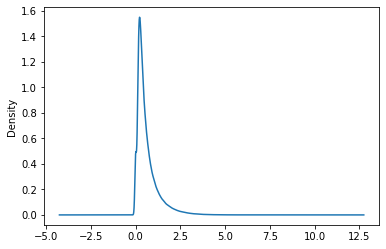

In [56]:
np.log1p(g_df.loc[:,'Tx']).plot.density()

In [57]:
!pip install catboost

In [69]:
from catboost import Pool, CatBoostClassifier


In [59]:
g_df = pd.merge(g_df,df_test,left_on='sku_',right_on='sku', how='left')

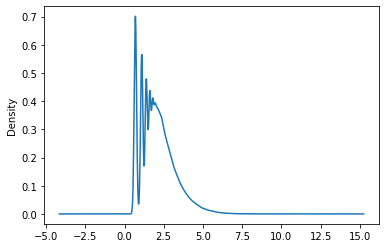

In [63]:
np.log1p(g_df.target_stock).plot.density()

In [68]:
g_df.loc[:,'target'] = (g_df.target_stock.fillna(g_df.target_stock.median())/g_df.Tx).apply(lambda x : x if x <30 else 30).apply(lambda x : x if x > 1 else 1).round(0)

In [77]:
# initialize data
train_data = g_df.loc[:,'current_price_count':'shipping_payment_shipping_payment'].sample(frac=.1,random_state=123)
train_label = g_df.loc[:,'target'].sample(frac=.1,random_state=123)
test_data = g_df.loc[~g_df.sku.isnull(),'current_price_count':'shipping_payment_shipping_payment']#.sample(frac=.1,random_state=1234)
# initialize Pool
train_pool = Pool(train_data, 
                  train_label)#, 
                  #cat_features=[0,2,5])
test_pool = Pool(test_data)#, 
                 #cat_features=[0,2,5]) 

# specify the training parameters 
model = CatBoostClassifier()
#train the model
model.fit(train_pool)
# make the prediction using the resulting model



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc166652550>]],
      dtype=object)

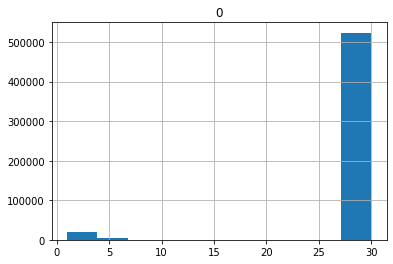

In [78]:
pd.DataFrame(model.predict(test_data)).hist()

In [ ]:
pd.DataFrame(model.predict_proba(test_data)).round(4).to_csv("test.csv.gz",compression='gzip',index=False,header=False)